In [1]:
!git clone https://github.com/YutongLei2020/CS-172B-Project.git
%cd ./CS-172B-Project/

Cloning into 'CS-172B-Project'...
remote: Enumerating objects: 34113, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 34113 (delta 25), reused 3 (delta 1), pack-reused 34058
Receiving objects: 100% (34113/34113), 58.62 MiB | 28.84 MiB/s, done.
Resolving deltas: 100% (27/27), done.
Updating files: 100% (35898/35898), done.
/content/CS-172B-Project


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K
import keras
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.regularizers import l2

from ResNet import ResNet18
import load_images
seed = 1234
tf.keras.utils.set_random_seed(seed)

In [6]:
X_train, Y_train, X_validation, Y_validation, X_test, Y_test = load_images.getDataset()
print(X_train.shape)
X_train = np.reshape(X_train,(21531,48,48,1))
print(X_train.shape)

(21531, 48, 48)
(21531, 48, 48, 1)


In [7]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        vertical_flip = True,
        fill_mode="nearest")


In [18]:
BS = 512
train_generator = train_datagen.flow(X_train, Y_train, batch_size=BS,shuffle = True)

In [19]:
model = ResNet18(7,(48,48,1))
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv2d_20 (Conv2D)             (None, 24, 24, 64)   576         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_20 (BatchN  (None, 24, 24, 64)  256         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 24, 24, 64)   0           ['batch_normalization_20[0

In [20]:
model.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    optimizer= Adam(learning_rate= 1e-2), 
    metrics=['accuracy']
)
# earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(filepath = 'models/Resnet18', 
        save_freq = 'epoch' ,
        save_best_only = True,
        save_weights_only=True,
        monitor = 'val_loss',
        mode ='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min',min_lr= 1e-11)

callbacks = [mcp_save,reduce_lr_loss]

In [21]:
history = model.fit(x =train_generator, batch_size= BS,
                    epochs=120,verbose=1, validation_data=(X_validation, Y_validation),callbacks = callbacks,shuffle = True)

Epoch 1/120
43/43 [==============================] - 18s 288ms/step - loss: 4.7941 - accuracy: 0.2090 - val_loss: 32079.8633 - val_accuracy: 0.1392 - lr: 0.0100
Epoch 2/120
43/43 [==============================] - 11s 261ms/step - loss: 3.6432 - accuracy: 0.2485 - val_loss: 4.9800 - val_accuracy: 0.2051 - lr: 0.0100
Epoch 3/120
43/43 [==============================] - 11s 259ms/step - loss: 2.7290 - accuracy: 0.2547 - val_loss: 2.5388 - val_accuracy: 0.1105 - lr: 0.0100
Epoch 4/120
43/43 [==============================] - 11s 259ms/step - loss: 2.3086 - accuracy: 0.2585 - val_loss: 2.1841 - val_accuracy: 0.2512 - lr: 0.0100
Epoch 5/120
43/43 [==============================] - 11s 251ms/step - loss: 2.1321 - accuracy: 0.2629 - val_loss: 2.1581 - val_accuracy: 0.2513 - lr: 0.0100
Epoch 6/120
43/43 [==============================] - 10s 225ms/step - loss: 2.1972 - accuracy: 0.2622 - val_loss: 2.9531 - val_accuracy: 0.1544 - lr: 0.0100
Epoch 7/120
43/43 [==============================] - 1

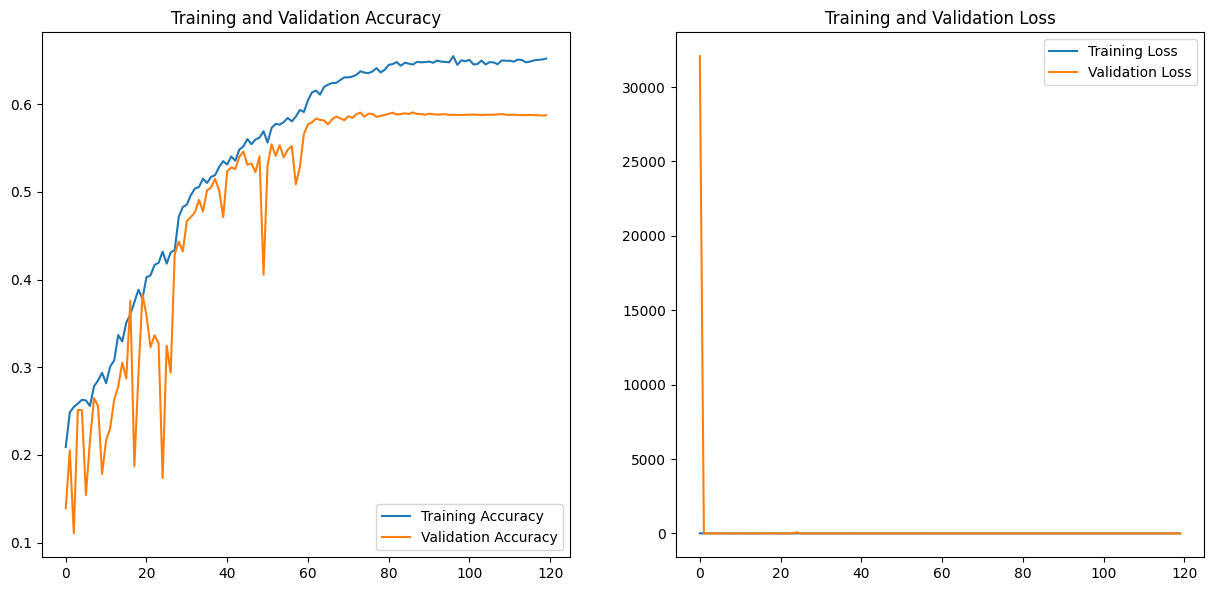

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(120)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
# best model prediction on test data
model.load_weights('models/Resnet18')
prediction = model.predict(X_test) # for each datapoint, gives a (1,7) vector contains probabilities

225/225 [==============================] - 3s 8ms/step


In [16]:
Y_prediction = np.argmax(prediction,axis = 1) # get the index(label) of highest probability for each testing datapoint
prediction_accuracy = np.mean(Y_prediction==Y_test)
print("The accuracy on test data is: ", prediction_accuracy)

The accuracy on test data is:  0.5763443856227362


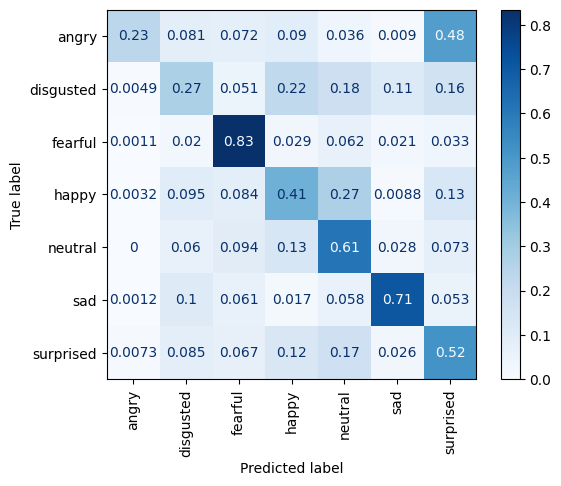

In [17]:
from sklearn.metrics import confusion_matrix, roc_auc_score,ConfusionMatrixDisplay
# confusion matrix
classes = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
cm = confusion_matrix(Y_test, Y_prediction, normalize= 'true')
disp = ConfusionMatrixDisplay(cm, display_labels = classes)
disp.plot(xticks_rotation = 'vertical',cmap=plt.cm.Blues)